In [1]:

from pathlib import Path
import os

import librosa
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import umap.umap_ as umap

from adjustText import adjust_text
from scipy.stats import spearmanr

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, davies_bouldin_score, silhouette_samples, silhouette_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize

import seaborn as sns




c:\Users\james\OneDrive\Documents\GitHub\Individual-Project-Win\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loads all embeddings from a specified file path. 

In [2]:
# Choose set of embeddings to work with
EMBED_PATH = Path("embeds_small")
ROOT_AUDIO = Path("../data/fma_small")  # adjust if needed

root = Path(EMBED_PATH)
embed_files = sorted(root.glob("*.npy"))
print(f"Found {len(embed_files)} embedding files")

Found 7997 embedding files


In [3]:
EMBED_PATH = Path("embeds_small")
MIN_T = 296
# snapshot before filtering
all_files = list(embed_files)

# Checks if files have the required 296 frames
try:
    is_valid
except NameError:
    def is_valid(path):
        try:
            a = np.load(path, allow_pickle=False, mmap_mode="r")
            ok = (a.ndim == 2) and (a.shape[0] >= MIN_T)
            del a  # release memmap handle
            return ok
        except Exception:
            return False

orig_n = len(embed_files)
embed_files = [f for f in all_files if is_valid(f)]
print(f"Kept {len(embed_files)} of {orig_n}")

# Reconstruct rows for the report table
rows = []
for f in all_files:
    a = np.load(f, allow_pickle=False, mmap_mode="r")
    frames = a.shape[0] if a.ndim == 2 else 0
    dim    = a.shape[1] if a.ndim == 2 else 0
    tid = int(Path(f).stem)
    rows.append((tid, str(f), frames, dim))

# List all embeddings with incorrect dimensions
df = pd.DataFrame(rows, columns=["track_id", "path", "frames", "dim"])
short_df = df.query("frames < @MIN_T").sort_values("frames")
print(short_df.head(20).to_string(index=False))




Kept 7994 of 7997
 track_id                    path  frames  dim
    98567 embeds_small\098567.npy       2  512
    98569 embeds_small\098569.npy      12  512
    98565 embeds_small\098565.npy      13  512


In [4]:

# Load embeddings
embeds = [np.load(f)[:MIN_T] for f in embed_files]
embeds = np.stack(embeds)  # shape: (num_files, *embedding_shape)
print(f"All embeddings stacked: {embeds.shape}")

All embeddings stacked: (7994, 296, 512)


# Embedding visualisations


-0.0983751 7.668402


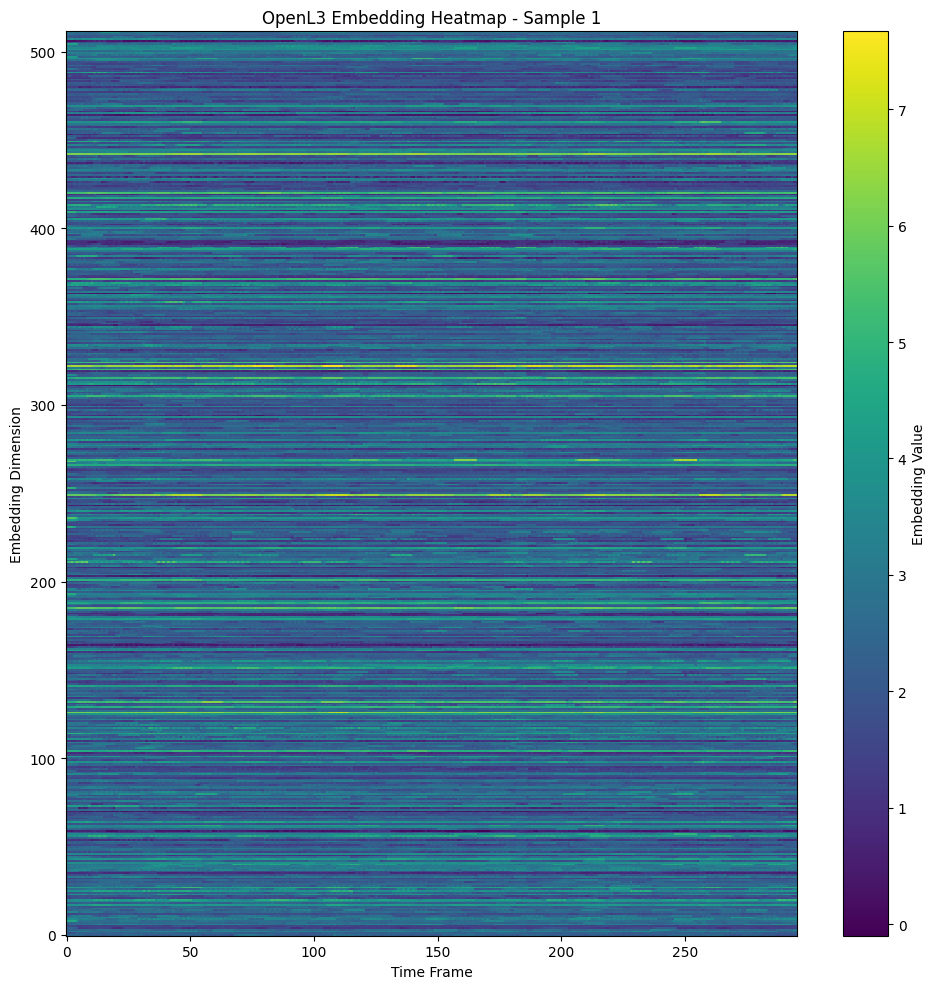

-0.22153533 7.3276114


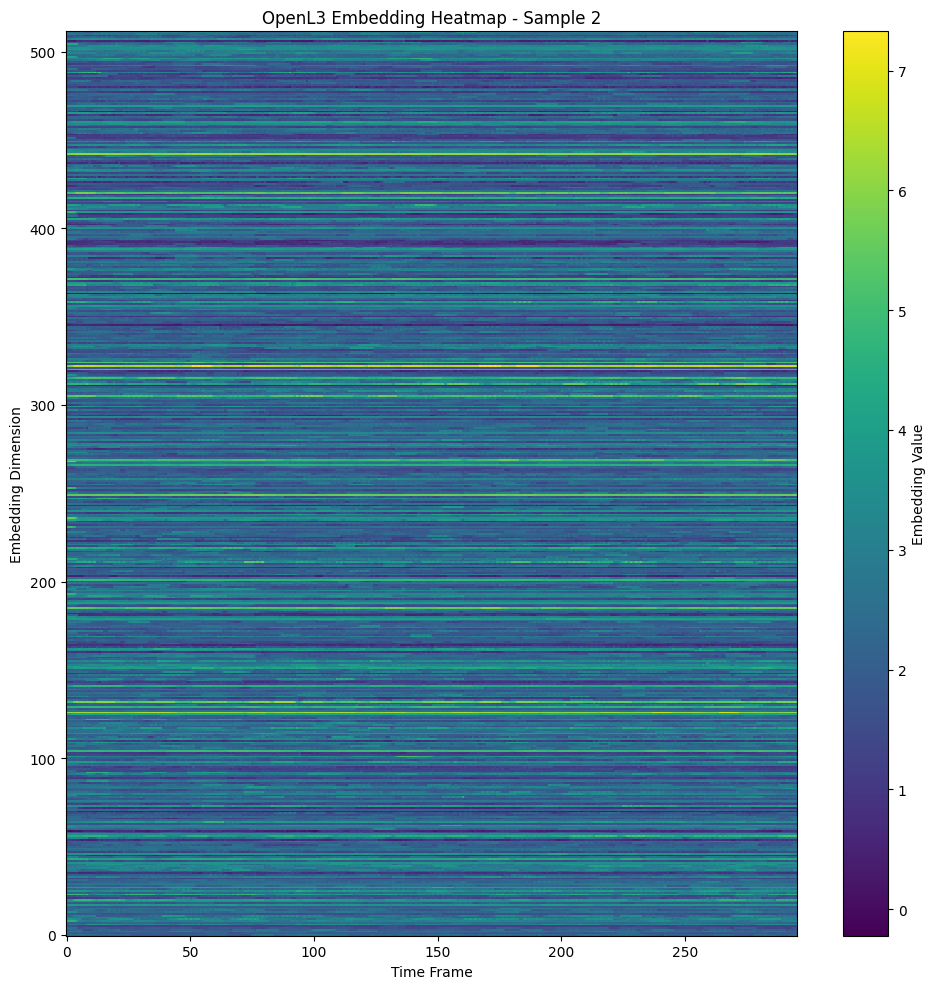

-0.20488505 7.261685


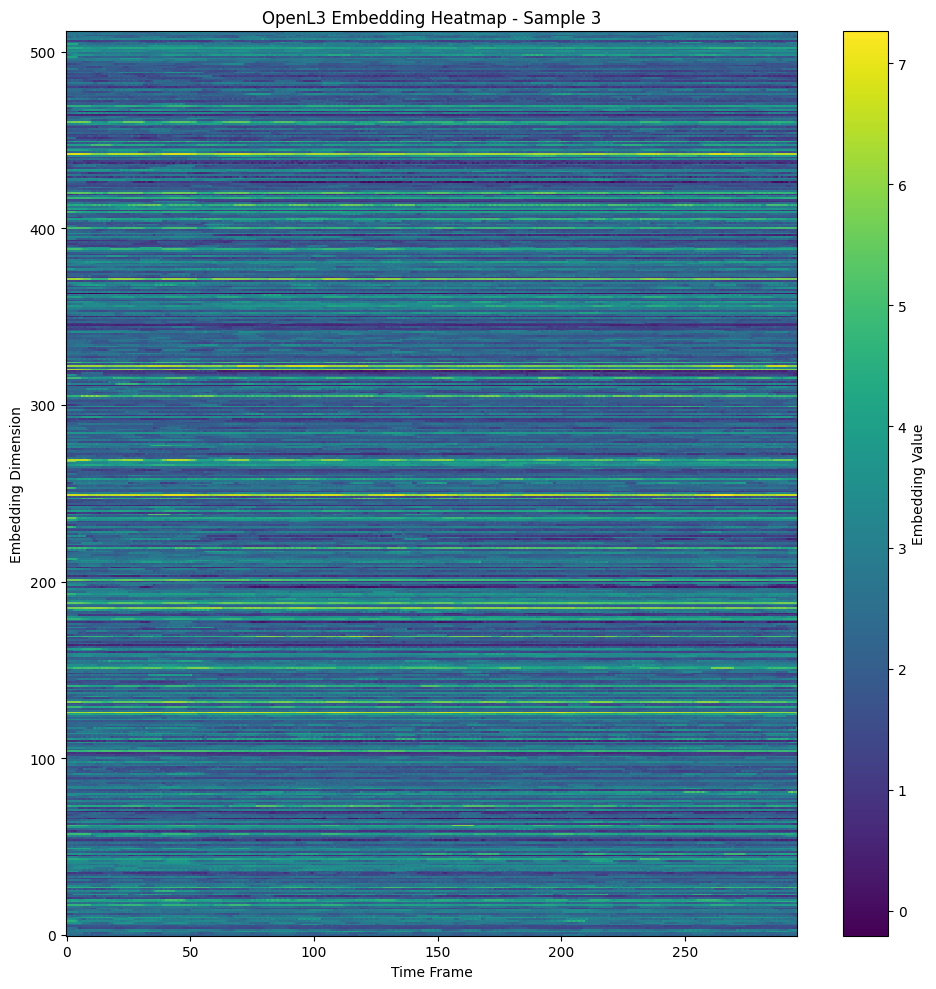

-0.25695512 6.63496


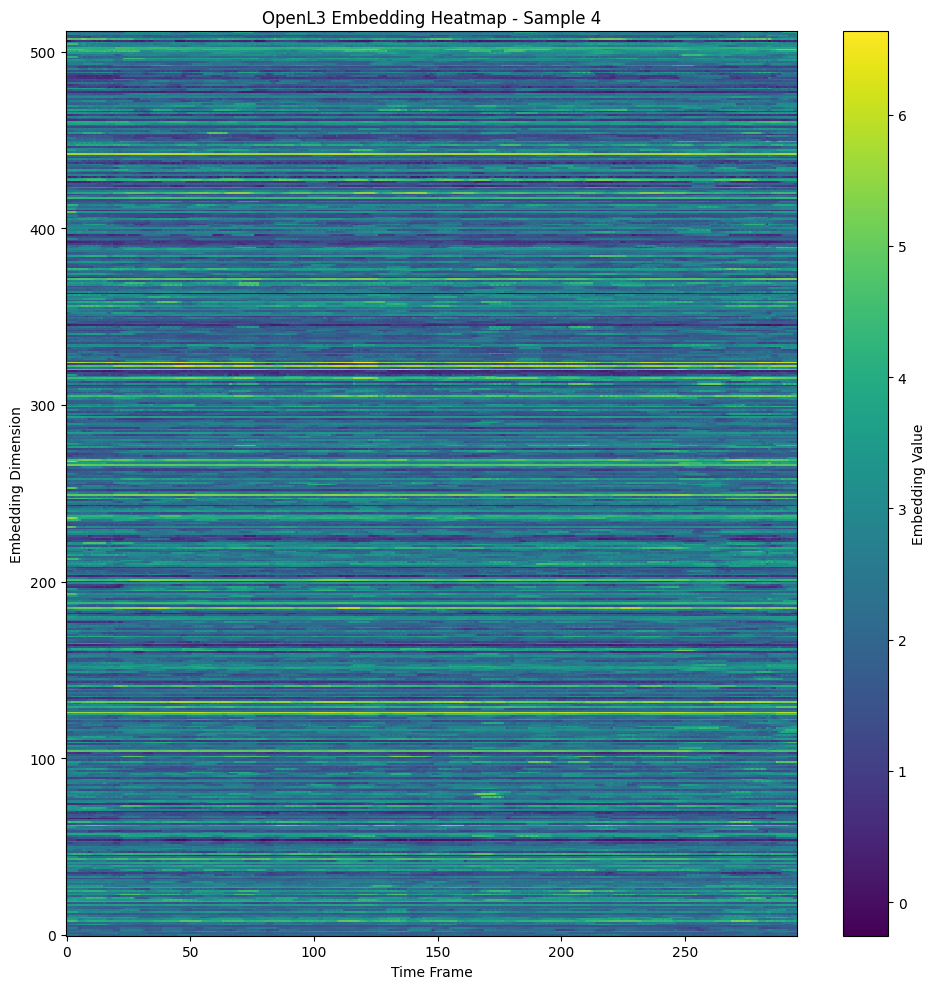

In [5]:

# Visualize the first X embeddings as a heatmap
N = 4

for i in range(N):
    plt.figure(figsize=(10, 10))
    plt.imshow(embeds[i].T, aspect='auto', origin='lower', interpolation='nearest')
    print(embeds[i].T.min(), embeds[i].T.max())
    plt.colorbar(label='Embedding Value')
    plt.xlabel('Time Frame')
    plt.ylabel('Embedding Dimension')
    plt.title(f'OpenL3 Embedding Heatmap - Sample {i+1}')
    plt.tight_layout()
    plt.show()



# Training 

In [6]:



tmp = Path("../data/fma_metadata/tracks.csv")

tracks = pd.read_csv(tmp, header=[0,1], index_col=0) \
         if pd.read_csv(tmp, nrows=0).columns.str.contains("Unnamed").any() \
         else pd.read_csv(tmp, index_col=0)


# Pull top-level genre per track_id
genre_top = tracks["track"]["genre_top"] if isinstance(tracks.columns, pd.MultiIndex) else tracks["genre_top"]

# Map each embedding file back to its track_id
track_ids = [int(f.stem) for f in embed_files]

arrays = [np.load(f) for f in embed_files]  
arrays = [a[:MIN_T] for a in arrays]  # trim to minimum length

X_all = np.stack([a.mean(axis=0) for a in arrays], axis=0)

# Align labels
labels = genre_top.reindex(track_ids)
mask = labels.notna().to_numpy()
X = X_all[mask]
y_str = labels[mask].to_numpy()

# Encode genre strings
enc = LabelEncoder().fit(y_str)
y = enc.transform(y_str)


if len(X) == 0:
    raise RuntimeError("No labels found for these track_ids in tracks.csv.")

# Load metadata robustly (MultiIndex or flat) 
def get_col(df, top, sub=None):
    if isinstance(df.columns, pd.MultiIndex):
        return df[(top, sub)]
    for cand in ([f"{top}.{sub}"] if sub else []) + [top, sub]:
        if cand and cand in df.columns: return df[cand]
    raise KeyError(f"Column {top}.{sub} not found")

# Extract FMA subset, split + genre info
subset_sr = get_col(tracks, "set", "subset")
split_sr  = get_col(tracks, "set", "split")
genre_sr  = get_col(tracks, "track", "genre_top")

meta = pd.DataFrame({
    "track_id": subset_sr.index.astype(int),
    "subset": subset_sr.values,
    "split":  split_sr.values,
    "genre_top": genre_sr.values
})


# Map embedding index to metadata
track_ids = np.array([int(f.stem) for f in embed_files])
emb_idx   = pd.DataFrame({"track_id": track_ids, "i": np.arange(len(track_ids))})

# Keep only tracks that exist in BOTH embeddings and metadata; restrict to 'small'
df = (emb_idx.merge(meta, on="track_id", how="inner")
            .query("subset == 'small' and genre_top == genre_top"))  # drop NaN genres

# Align embeddings and labels to dataset order
X_use = X_all[df["i"].to_numpy()]
y_str = df["genre_top"].to_numpy()

enc = LabelEncoder().fit(y_str)  # safe to fit on all labels (no leakage of targets)
y_all = enc.transform(y_str)

# Boolean masks for train/val/test splits
is_tr  = (df["split"] == "training").to_numpy() # 80
is_va  = (df["split"] == "validation").to_numpy() # 10
is_te  = (df["split"] == "test").to_numpy() # 10

# Create split datasets
X_tr, y_tr = X_use[is_tr], y_all[is_tr]
X_va, y_va = X_use[is_va], y_all[is_va]
X_te, y_te = X_use[is_te], y_all[is_te]

print(f"{len(y_tr)} train, {len(y_va)} val, {len(y_te)} test "
      f"• {X_tr.shape[1]} dims • {len(enc.classes_)} classes")

# Scale features and train classifier
scaler = StandardScaler().fit(X_tr)
clf = LogisticRegression(max_iter=5000, class_weight="balanced")
clf.fit(scaler.transform(X_tr), y_tr)

# Evaluate on validation and test sets 
print("Validation:")
print(classification_report(y_va, clf.predict(scaler.transform(X_va)),
                            target_names=enc.classes_, digits=3))
print("Test:")
print(classification_report(y_te, clf.predict(scaler.transform(X_te)),
                            target_names=enc.classes_, digits=3))


6394 train, 800 val, 800 test • 512 dims • 8 classes
Validation:
               precision    recall  f1-score   support

   Electronic      0.477     0.630     0.543       100
 Experimental      0.416     0.470     0.441       100
         Folk      0.641     0.660     0.650       100
      Hip-Hop      0.698     0.670     0.684       100
 Instrumental      0.512     0.440     0.473       100
International      0.667     0.580     0.620       100
          Pop      0.253     0.210     0.230       100
         Rock      0.670     0.670     0.670       100

     accuracy                          0.541       800
    macro avg      0.542     0.541     0.539       800
 weighted avg      0.542     0.541     0.539       800

Test:
               precision    recall  f1-score   support

   Electronic      0.637     0.510     0.567       100
 Experimental      0.297     0.380     0.333       100
         Folk      0.205     0.160     0.180       100
      Hip-Hop      0.658     0.790     0.718 

# ROC curves


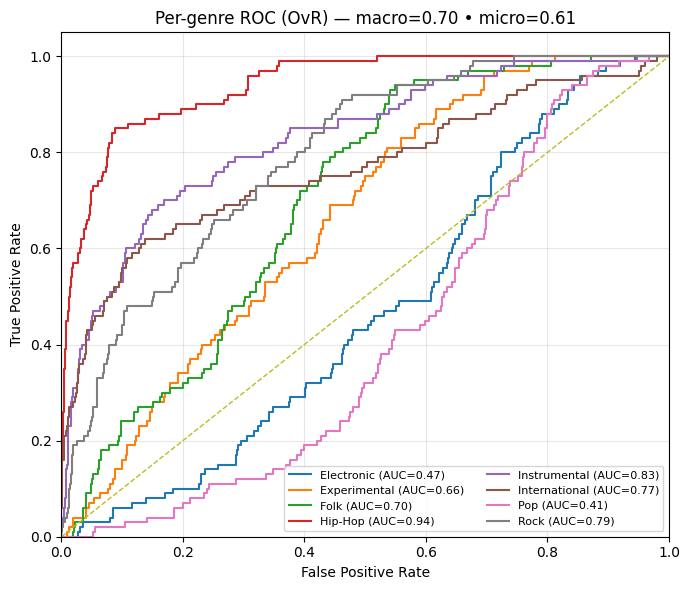

In [7]:

# Probabilities on test set
y_score = clf.predict_proba(X_te)

# Binarize test labels for OvR ROC
n_classes = len(enc.classes_)
y_te_bin = label_binarize(y_te, classes=np.arange(n_classes))

# Some genres might have 0 positives in y_te, skip those to avoid undefined curves
pos_counts = y_te_bin.sum(axis=0)
valid = pos_counts > 0

fpr, tpr, roc_auc = {}, {}, {}
for i in np.where(valid)[0]:
    fpr[i], tpr[i], _ = roc_curve(y_te_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Aggregate AUCs
auc_macro = roc_auc_score(y_te, y_score, multi_class="ovr", average="macro")
auc_micro = roc_auc_score(y_te_bin[:, valid], y_score[:, valid], average="micro")

# Plot per-genre ROC
plt.figure(figsize=(7, 6))
for i in np.where(valid)[0]:
    plt.plot(fpr[i], tpr[i], label=f"{enc.classes_[i]} (AUC={roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "--", lw=1)
plt.xlim(0, 1); plt.ylim(0, 1.05)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"Per-genre ROC (OvR) — macro={auc_macro:.2f} • micro={auc_micro:.2f}")
plt.legend(loc="lower right", fontsize=8, ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Confusion matrix

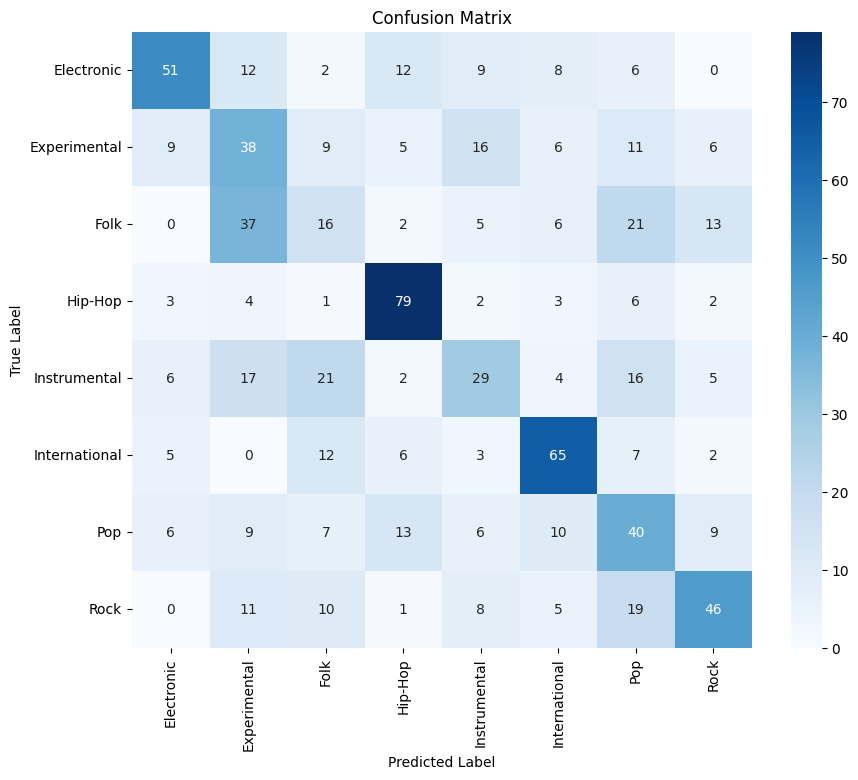

In [8]:


# Standardise test features with training-fitted scaler, then predict class labels
y_pred = clf.predict(scaler.transform(X_te))

# Compute  + plot confusion matrix
cm = confusion_matrix(y_te, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=enc.classes_, yticklabels=enc.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Sensitivity to cross-genre variability

## UMAP visualisations

c:\Users\james\OneDrive\Documents\GitHub\Individual-Project-Win\env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


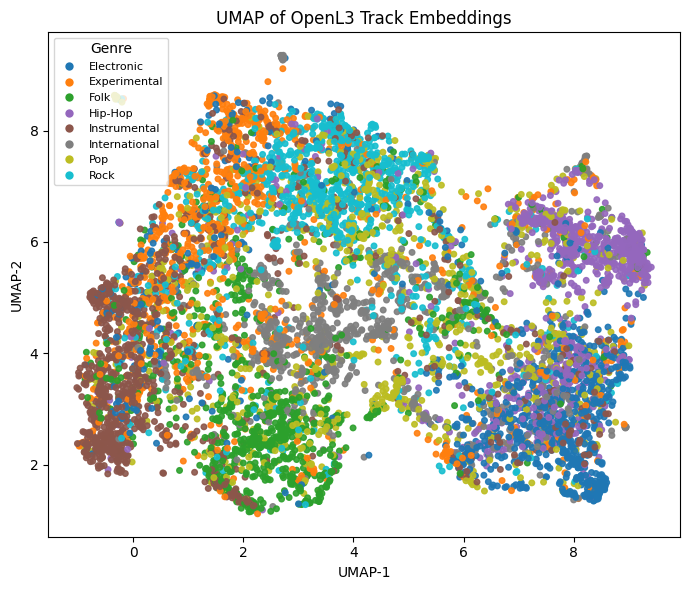

In [9]:


# X: (n_tracks, 512) pooled per-track embeddings; y_str: string genres
enc = LabelEncoder().fit(y_str)
y = enc.transform(y_str)
classes = enc.classes_ 


# Preprocessing and embedding
Xn = StandardScaler().fit_transform(X)                 # stabilise scales
Xp = PCA(n_components=50, random_state=0).fit_transform(Xn)  # denoise a bit
um = umap.UMAP(n_neighbors=20, min_dist=0.1, metric="cosine", random_state=0)
Z = um.fit_transform(Xp) 

# Discrete colour mapping with 8 classes
K = len(classes)
cmap = plt.get_cmap("tab10", K) 

plt.figure(figsize=(7,6))
sc = plt.scatter(Z[:,0], Z[:,1], s=16, c=y, cmap=cmap, vmin=0, vmax=K-1, alpha=0.9)
plt.title("UMAP of OpenL3 Track Embeddings")
handles = [plt.Line2D([], [], marker='o', ls='', label=cls) for cls in enc.classes_]
plt.legend(handles, enc.classes_, loc="best", fontsize=8)
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2"); plt.tight_layout()

# Legend with matching colors
handles = [Line2D([], [], marker='o', linestyle='', markersize=6,
                  markerfacecolor=cmap(i), markeredgecolor='none', label=cls)
           for i, cls in enumerate(classes)]
plt.legend(handles=handles, loc="best", fontsize=8, title="Genre")
plt.tight_layout()
plt.savefig("graphics/umap_plot.png", dpi=300, bbox_inches='tight')
plt.show()




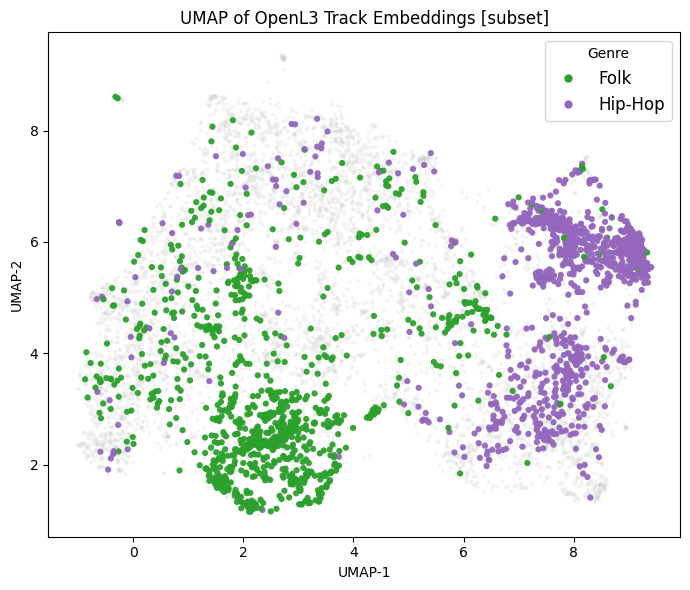

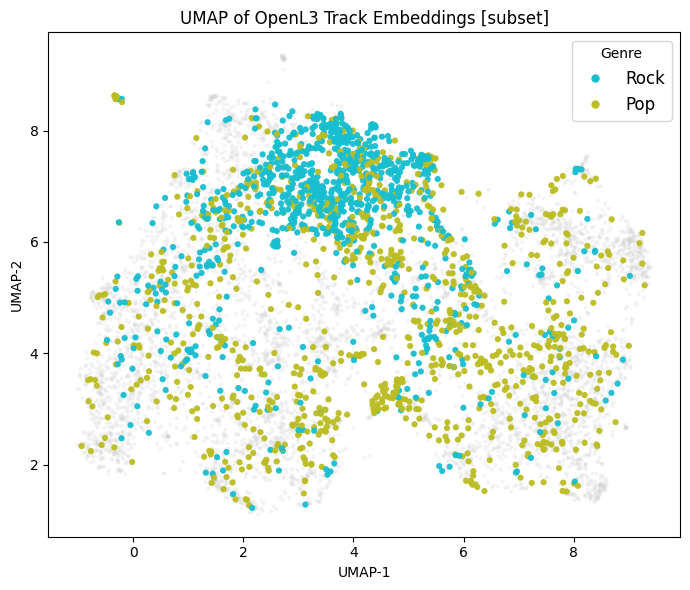

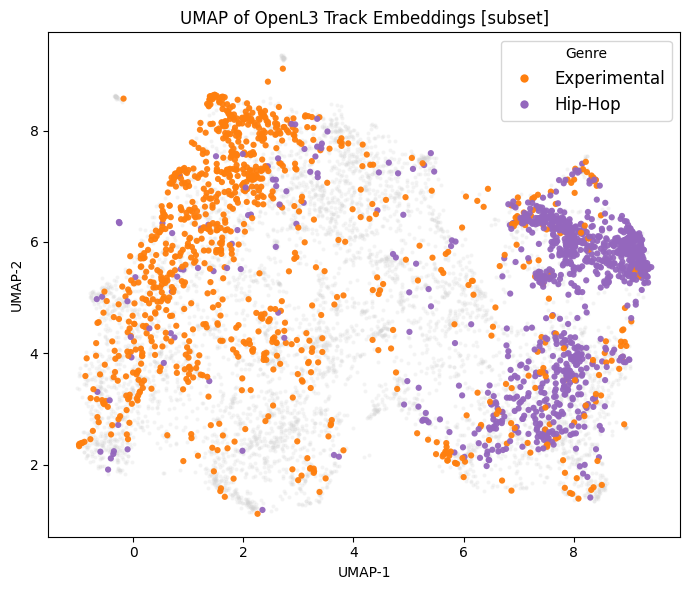

In [10]:
CLASS2IDX = {c: i for i, c in enumerate(classes)}
GLOBAL_CMAP = plt.get_cmap("tab10", len(classes))  # same as before

def plot_umap_subset(selected_classes, Z, y, classes, *, background=False, filename=None):
    # Map requested class names → indices, validate
    try:
        sel_idx = np.array([CLASS2IDX[c] for c in selected_classes], dtype=int)
    except KeyError as e:
        raise ValueError(f"Unknown class '{e.args[0]}'. Use one of: {list(classes)}")

    # Mask points of interest
    mask = np.isin(y, sel_idx)

    plt.figure(figsize=(7, 6))

    # Optional grey background for context
    if background:
        plt.scatter(Z[:, 0], Z[:, 1], s=8, c="lightgray", alpha=0.25, linewidths=0)

    # Foreground: only the selected classes, colored by their global indices
    plt.scatter(
        Z[mask, 0], Z[mask, 1],
        s=20, c=y[mask],
        cmap=GLOBAL_CMAP, vmin=0, vmax=len(classes)-1,
        alpha=0.95, linewidths=0
    )

    # Legend with matching global colors
    handles = [
        Line2D([], [], marker="o", linestyle="", markersize=6,
               markerfacecolor=GLOBAL_CMAP(i), markeredgecolor="none", label=classes[i])
        for i in sel_idx
    ]
    plt.legend(handles=handles, loc="best", fontsize=12, title="Genre")

    plt.title("UMAP of OpenL3 Track Embeddings [subset]")
    plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2"); plt.tight_layout()

    if filename:
        plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

plot_umap_subset(["Folk", "Hip-Hop"], Z, y, classes, background=True,
                 filename="graphics/umap_folk_hiphop.png")

plot_umap_subset(["Rock", "Pop"], Z, y, classes, background=True,
                 filename="graphics/umap_rock_pop.png")

plot_umap_subset(["Experimental", "Hip-Hop"], Z, y, classes, background=True,
                 filename="graphics/umap_experimental_hiphop.png")


In [11]:


sil_score = silhouette_score(X, y, metric='cosine')  # X = pooled embeddings
print(f"Silhouette score: {sil_score:.3f}")


Silhouette score: -0.033


In [12]:

dbi = davies_bouldin_score(X, y)  # X = pooled embeddings
print(f"Davies-Bouldin Index: {dbi:.3f}")

Davies-Bouldin Index: 4.299


# Sensitivity to cross-genre variability

In [13]:


TABLE_LENGTH = 20

# Table of most ambiguous tracks (lowest silhouette scores)"""
s_i = silhouette_samples(X, y, metric="euclidean")
ambig_idx = np.argsort(s_i)[:TABLE_LENGTH]  # most negative/lowest silhouettes
ambig_tracks = [track_ids[i] for i in ambig_idx]
ambig_true = enc.inverse_transform(y[ambig_idx])
ambig_pred = enc.inverse_transform(clf.predict(X[ambig_idx]))
pd.DataFrame({"track_id": ambig_tracks, "Silhouette": s_i[ambig_idx],
              "True genre": ambig_true, "Predicted genre": ambig_pred}).head(TABLE_LENGTH)



,track_id,Silhouette,True genre,Predicted genre
0,134796,-0.401867,Instrumental,Hip-Hop
1,119579,-0.365281,Experimental,Hip-Hop
2,120161,-0.362245,Experimental,Hip-Hop
3,112585,-0.361522,Experimental,Hip-Hop
4,132568,-0.347291,Instrumental,Hip-Hop
5,57938,-0.346042,Experimental,Hip-Hop
6,126183,-0.344857,Instrumental,Hip-Hop
7,29750,-0.339878,Experimental,Hip-Hop
8,126182,-0.328048,Instrumental,Hip-Hop
9,1277,-0.322819,Experimental,Hip-Hop


## kNN purity

In [14]:


k = 6
nn = NearestNeighbors(n_neighbors=k+1, metric='cosine').fit(X)
distances, indices = nn.kneighbors(X)


# Skip the first neighbor (itself)
neighbor_labels = y[indices[:, 1:]]
purity = np.mean([np.mean(lbls == y[i]) for i, lbls in enumerate(neighbor_labels)])
print(f"{k}-NN purity: {purity:.3f}")

6-NN purity: 0.553


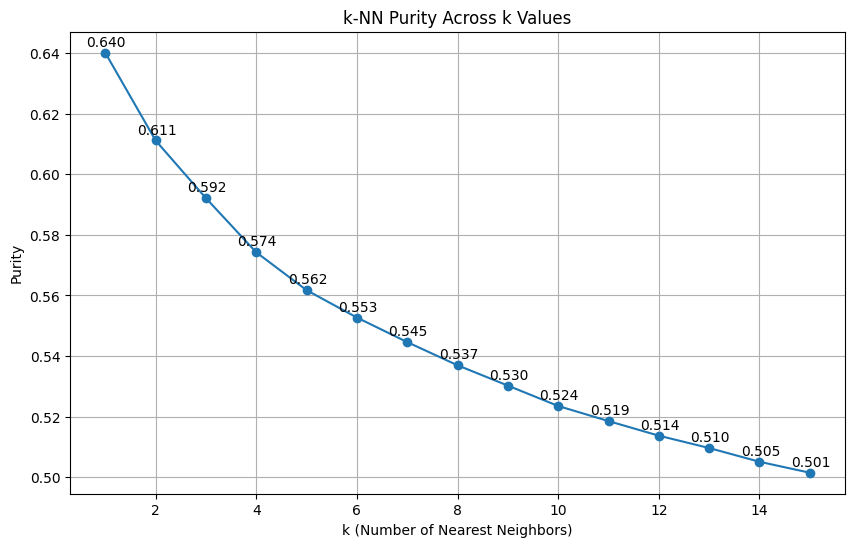

In [15]:



def knn_purity(X, y, k):
    nn = NearestNeighbors(n_neighbors=k+1, metric='cosine').fit(X)
    _, indices = nn.kneighbors(X)
    neighbor_labels = y[indices[:, 1:]]  # skip itself
    return np.mean([np.mean(lbls == y[i]) for i, lbls in enumerate(neighbor_labels)])

# test k=1 to 15
k_values = range(1, 16) 
purities = [knn_purity(X, y, k) for k in k_values]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(k_values, purities, marker='o')

texts = [ax.text(k, p, f"{p:.3f}", ha='center', va='bottom')
         for k, p in zip(k_values, purities)]
adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', lw=0.1))

ax.set_xlabel("k (Number of Nearest Neighbors)")
ax.set_ylabel("Purity")
ax.set_title("k-NN Purity Across k Values")
ax.grid(True)
plt.show()

# Semantic interpretability

In [16]:

# Path to metadata - adjust if needed
meta_dir = Path("../data/fma_metadata")  

rows = []
rng = np.random.default_rng(0)

def read_flat(path):
    # Try multi-index headers first, then fall back
    for header in ([0, 1, 2], [0, 1], None):
        try:
            df = pd.read_csv(path, index_col=0, header=header)
            break
        except Exception:
            continue
    # Flatten multi-index columns
    # ('echonest','audio_features','danceability') → "echonest.audio_features.danceability"
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['.'.join(str(x) for x in tup if str(x) != '') for tup in df.columns]
    return df

# echonest.csv stores audio features
en_flat = read_flat(meta_dir / "echonest.csv")  

# Flatten columns if necessary
if isinstance(en_flat.columns, pd.MultiIndex):
    en_flat.columns = en_flat.columns.map(lambda tpl: ".".join(map(str, tpl)))

# tempo, danceability, loudness etc
attrs = [c for c in en_flat.columns if c.startswith("echonest.audio_features.")]

idx = pd.Index(np.asarray(track_ids, dtype="int64"), name="track_id")


for attr in attrs:
    vals = en_flat.reindex(idx)[attr] # reindex - match embedding order
    m = vals.notna().to_numpy() # mask for valid values
    if m.sum() < 200: # skip very sparse attributes
        continue

    # Embeddings subset per attribute
    X_use = X_all[m]
    a = vals[m].astype(float).to_numpy() # numeric attribute values

    # PCA (per-attr subset to avoid NaN alignment issues)
    Xz = StandardScaler().fit_transform(X_use)
    pca = PCA(n_components=2, random_state=0).fit(Xz)
    Z = pca.transform(Xz)
    evr1, evr2 = pca.explained_variance_ratio_[:2]

    # Association of attribute with PC1
    rho, p = spearmanr(Z[:, 0], a)

    # kNN attribute purity (q-quantile bins) + shuffled baseline
    bins = pd.qcut(a, q=5, labels=False, duplicates="drop")
    k = min(10, len(a) - 1)
    nn = NearestNeighbors(n_neighbors=k+1, metric="cosine").fit(Xz)
    nbrs = nn.kneighbors(Xz, return_distance=False)[:, 1:]
    purity = np.mean([(bins[i] == bins[nbrs[i]]).mean() for i in range(len(bins))])

    # Permutation baseline for purity
    iters = 200
    perm_scores = []
    for _ in range(iters):
        b = bins.copy(); rng.shuffle(b)
        perm_scores.append(np.mean([(b[i] == b[nbrs[i]]).mean() for i in range(len(b))]))
    perm_scores = np.asarray(perm_scores)

    # Collect metrics
    rows.append({
        "attr": attr.split(".")[-1],
        "n": len(a),
        "pc1_var": evr1,
        "pc2_var": evr2,
        "spearman_pc1": rho,
        "spearman_p": p,
        "knn_purity": purity,
        "shuffle_mean": perm_scores.mean(),
        "shuffle_std": perm_scores.std(),
        "purity_lift": purity - perm_scores.mean(),
    })

results = (pd.DataFrame(rows)
             .sort_values(["purity_lift", "spearman_pc1"], ascending=False)
             .reset_index(drop=True))

# Pretty print
display_cols = ["attr","n","pc1_var","pc2_var","spearman_pc1","spearman_p",
                "knn_purity","shuffle_mean","purity_lift"]
print(results[display_cols].round(3).to_string(index=False))


            attr    n  pc1_var  pc2_var  spearman_pc1  spearman_p  knn_purity  shuffle_mean  purity_lift
    acousticness 1294    0.145    0.131        -0.402        0.00       0.383         0.199        0.183
instrumentalness 1294    0.145    0.131        -0.195        0.00       0.347         0.199        0.148
          energy 1294    0.145    0.131         0.628        0.00       0.345         0.199        0.146
    danceability 1294    0.145    0.131         0.042        0.13       0.343         0.200        0.143
     speechiness 1294    0.145    0.131         0.318        0.00       0.330         0.199        0.131
         valence 1294    0.145    0.131         0.174        0.00       0.294         0.199        0.094
        liveness 1294    0.145    0.131         0.201        0.00       0.241         0.200        0.042
           tempo 1294    0.145    0.131         0.138        0.00       0.236         0.199        0.036


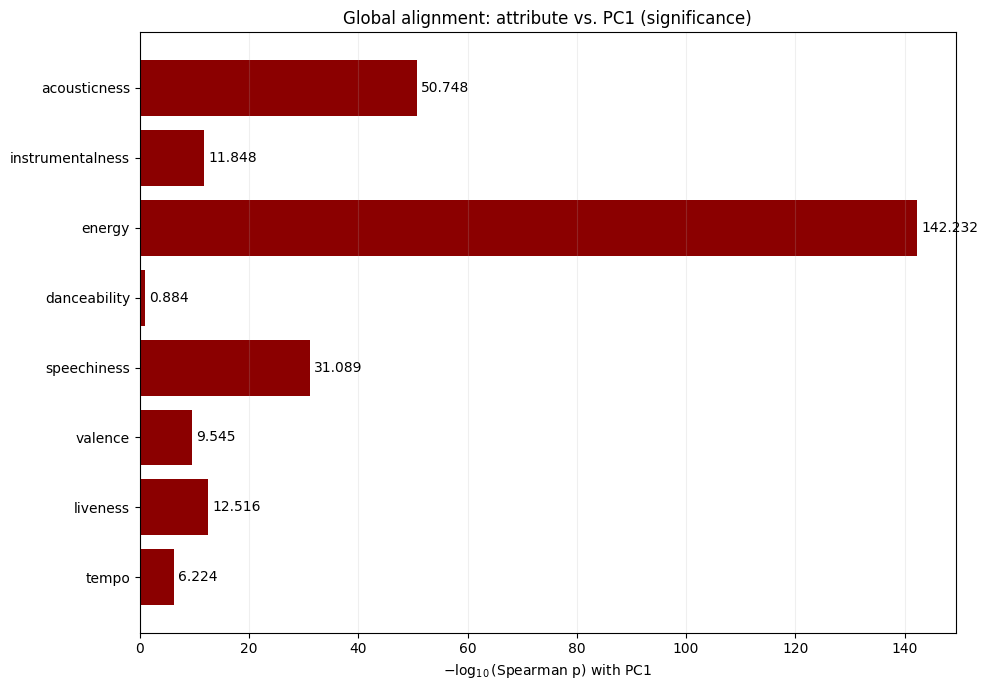

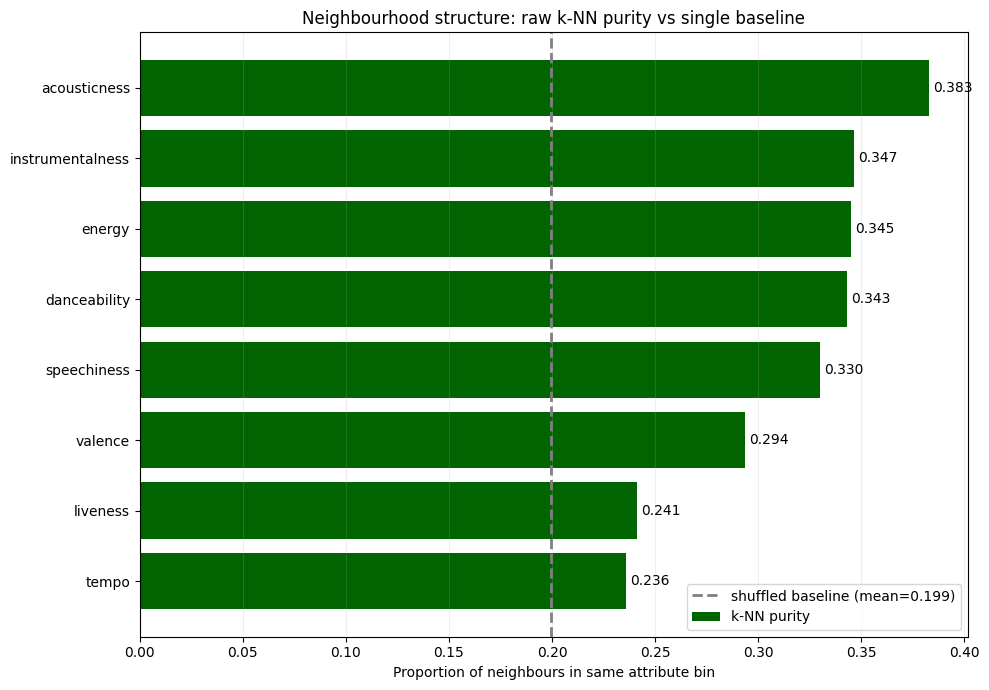

In [17]:
# Get top attributes by purity lift
df = results.sort_values("purity_lift", ascending=False).copy()

# For readability: plot significance as -log10(p). Clip tiny p to avoid inf.
df["neglog10_p"] = -np.log10(df["spearman_p"].clip(lower=1e-300))


# Attribute vs. PC1 
plt.figure(figsize=(10, 7))
bars = plt.barh(df["attr"], df["neglog10_p"], color='darkred')
ax = plt.gca()
ax.invert_yaxis()
ax.bar_label(bars, labels=[f"{v:.3f}" for v in df["neglog10_p"].to_numpy()], padding=3)
plt.xlabel(r"$-\log_{10}$(Spearman p) with PC1")
plt.title("Global alignment: attribute vs. PC1 (significance)")
plt.grid(axis="x", alpha=0.2)
plt.tight_layout()
plt.savefig("graphics/spearman_significance_bar.png", dpi=200, bbox_inches="tight")
plt.show()


# k-NN purity vs shuffled baseline (side-by-side)
plt.figure(figsize=(10, 7))
bars = plt.barh(df["attr"], df["knn_purity"], color='darkgreen', label="k-NN purity")
ax = plt.gca()
ax.invert_yaxis()
ax.bar_label(bars, labels=[f"{v:.3f}" for v in df["knn_purity"].to_numpy()], padding=3)
# One baseline across all attrs (mean shuffled purity)
baseline = float(df["shuffle_mean"].mean())
ax.axvline(baseline, color='gray', linestyle='--', linewidth=2,
           label=f"shuffled baseline (mean={baseline:.3f})")

plt.xlabel("Proportion of neighbours in same attribute bin")
plt.title("Neighbourhood structure: raw k-NN purity vs single baseline")
plt.legend()
plt.grid(axis="x", alpha=0.2)
plt.tight_layout()
plt.savefig("graphics/knn_purity_vs_baseline.png", dpi=200, bbox_inches="tight")
plt.show() 